In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from utils.func_utils import accept, jacobian, autocovariance, get_log_likelihood, get_data, binarize, normal_kl
from utils.distributions import Gaussian, GMM, GaussianFunnel, gen_ring
from utils.layers import Linear, Parallel, Sequential, Zip, ScaleTanh
from utils.dynamics import Dynamics

In [3]:
tf.reset_default_graph()

In [4]:
with tf.variable_scope('encoder'):
    encoder = Sequential([
        Linear(784, 1024, scope='encoder_1'),
        tf.nn.softplus,
        Linear(1024, 1024, scope='encoder_2'),
        tf.nn.softplus,
        Parallel([
            Linear(1024, 50, scope='encoder_mean'),
            Linear(1024, 50, scope='encoder_std'),
        ])
    ])

with tf.variable_scope('decoder'):
    decoder = Sequential([
        Linear(50, 1024, scope='decoder_1'),
        tf.nn.softplus,
        Linear(1024, 1024, scope='decoder_2'),
        tf.nn.softplus,
        Linear(1024, 784, scope='decoder_3', factor=0.01)
    ])

In [5]:
from tensorflow.examples.tutorials.mnist import input_data

In [6]:
def get_data():
  mnist = input_data.read_data_sets("MNIST_data/", validation_size=0)
  train_data = mnist.train.next_batch(60000, shuffle=False)[0]
  test_data = mnist.test.next_batch(10000, shuffle=False)[0]
  return train_data, test_data

In [7]:
float_x_train, float_x_test = get_data()

N = float_x_train.shape[0]
D = float_x_train.shape[1]

float_x_train = float_x_train[np.random.permutation(N), :]
float_x_test = float_x_test[np.random.permutation(float_x_test.shape[0]), :]

x_train = binarize(float_x_train)
x_test = binarize(float_x_test)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [8]:
def var_from_scope(scope_name):
    return tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=scope_name)

In [9]:
inp = tf.placeholder(tf.float32, shape=(None, 784))

mu, log_sigma = encoder(inp)

noise = tf.random_normal(tf.shape(mu))

latent_q = mu + noise * tf.exp(log_sigma)

logits = decoder(latent_q)

kl = normal_kl(mu, tf.exp(log_sigma), 0., 1.)
bce = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=inp, logits=logits), axis=1)
elbo = tf.reduce_mean(kl+bce)
opt = tf.train.AdamOptimizer(0.001)
elbo_train_op = opt.minimize(elbo, var_list=var_from_scope('encoder'))

In [10]:
def energy(z, aux=None):
    logits = decoder(z)
    log_posterior = -tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=aux, logits=logits), axis=1)
    log_prior = -0.5 * tf.reduce_sum(tf.square(z), axis=1)
    return -log_posterior - log_prior

In [11]:
with tf.variable_scope('sampler'):
    x_dim = 50

    size1 = 200
    size2 = 200

    encoder_sampler = Sequential([
        Linear(784, 512, scope='encoder_1'),
        tf.nn.softplus,
        Linear(512, 512, scope='encoder_2'),
        tf.nn.softplus,
        Linear(512, size1, scope='encoder_3'),
    ])
    
    def net_factory(x_dim, scope, factor):
        with tf.variable_scope(scope):
            net = Sequential([
                Zip([
                    Linear(x_dim, size1, scope='embed_1', factor=0.33),
                    Linear(x_dim, size1, scope='embed_2', factor=factor * 0.33),
                    Linear(2, size1, scope='embed_3', factor=0.33),
                    encoder_sampler,
                ]),
                sum,
                tf.nn.relu,
                Linear(size1, size2, scope='linear_1'),
                tf.nn.relu,
                Parallel([
                    Sequential([
                        Linear(size2, x_dim, scope='linear_s', factor=0.01), 
                        ScaleTanh(x_dim, scope='scale_s')
                    ]),
                    Linear(size2, x_dim, scope='linear_t', factor=0.01),
                    Sequential([
                        Linear(size2, x_dim, scope='linear_f', factor=0.01),
                        ScaleTanh(x_dim, scope='scale_f'),
                    ])
                ])
            ])
        return net
    
    class Network(object):
        def __init__(self, x_dim, scope='Network', factor=1.0):
            with tf.variable_scope(scope):
                self.embed_1 = Linear(x_dim, size1, scope='embed_1', factor=1.0 / 3)
                self.embed_2 = Linear(x_dim, size1, scope='embed_2', factor=factor * 1.0 / 3)
                self.embed_3 = Linear(2, size1, scope='embed_3', factor=1.0 / 3)

                self.linear_1 = Linear(size1, size2, scope='linear_1')

                self.scaling_S = tf.exp(tf.get_variable('scale_s', shape=(1, x_dim), initializer=tf.constant_initializer(0.)))
                self.scaling_F = tf.exp(tf.get_variable('scale_f', shape=(1, x_dim), initializer=tf.constant_initializer(0.)))      
                self.linear_s = Linear(size2, x_dim, scope='linear_s', factor=0.001)
                self.linear_t = Linear(size2, x_dim, scope='linear_t', factor=0.001)
                self.linear_f = Linear(size2, x_dim, scope='linear_f', factor=0.001)

        def hidden(self, x, v, t, aux=None):
            z1 = self.embed_1(x)
            z2 = self.embed_2(v)
            z3 = self.embed_3(t)
            z4 = encoder_sampler(aux)

            h1 = tf.nn.relu(z1 + z2 + z3 + z4)

            h2 = tf.nn.relu(self.linear_1(h1))
            # h3 = tf.nn.relu(self.linear_2(h2))
            return tf.nn.relu(h2)
        
        def __call__(self, inp):
            x, v, t, aux = inp
            h = self.hidden(x, v, t, aux=aux)
            S = self.scaling_S * tf.nn.tanh(self.linear_s(h))
            F = self.scaling_F * tf.nn.tanh(self.linear_f(h))
            T = self.linear_t(h)
            return S, T, F 

#     def net_factory(x_dim, scope, factor):
#             return Network(x_dim, scope=scope, factor=factor)

    dynamics = Dynamics(x_dim, energy, T=5, eps=0.1, hmc=False, net_factory=net_factory, eps_trainable=True, use_temperature=False)

In [ ]:
def boolean_mask(x, mask):
    return tf.boolean_mask(x, mask), tf.boolean_mask(x, tf.logical_not(mask))

def inverse_boolean_mask(x_true, x_false, mask):
    n = tf.shape(mask)[0]
    rest = x_true.get_shape().as_list()[1:]
    shape = [n] + rest

    ind1 = tf.expand_dims(gather_indices(mask), 1)
    ind2 = tf.expand_dims(gather_indices(tf.logical_not(mask)), 1)

    z = tf.scatter_nd(ind1, x_true, shape) + tf.scatter_nd(ind2, x_false, shape)
    return z

def gather_indices(mask):
    n = tf.shape(mask)[0]
    return tf.boolean_mask(tf.range(n), mask)

In [12]:
def inverse_boolean_mask(x_true, x_false, mask):
    n = tf.shape(mask)[0]
    ind = tf.dynamic_partition(tf.range(n), mask, 2)
    return tf.dynamic_stitch(data=[x_true, x_false], indices=ind)

def loss_func(x, Lx, px):
    v1 = tf.reduce_sum(tf.square(x - Lx), axis=1) * px + 1e-4
    scale = 1.0

    sampler_loss = 0.
    sampler_loss += scale * (tf.reduce_mean(1.0 / v1))
    sampler_loss += (- tf.reduce_mean(v1)) / scale
    return sampler_loss

def tf_accept(x, Lx, px):
    mask = (px - tf.random_uniform(tf.shape(px)) >= 0.)
    return tf.where(mask, Lx, x)

sampler_loss = 0.

latent = latent_q
hmc_steps = 5
for t in range(hmc_steps):
    mask = tf.cast(tf.random_uniform((tf.shape(latent)[0], 1), maxval=2, dtype=tf.int32), tf.float32)

    latent = tf.stop_gradient(latent)
    x1 = mask * latent
    x2 = (1-mask) * latent

    Lx1, _, px1 = dynamics.forward(x1, aux=inp)
    Lx2, _, px2 = dynamics.backward(x2, aux=inp)
    
    Lx = mask * Lx1 + (1 - mask) * Lx2
    px = tf.squeeze(mask, axis=1) * px1 + tf.squeeze(1 - mask, axis=1) * px2

    sampler_loss += 1.0 / hmc_steps * loss_func(latent, Lx, px)
    
    latent = tf_accept(latent, Lx, px)

latent_T = latent

In [ ]:
dum2 = tf.placeholder(tf.float32, shape=(None, 5))

dum = tf.cast(tf.random_uniform((tf.shape(dum2)[0],), maxval=2, dtype=tf.int32), tf.float32)


with tf.Session() as sess:
    print sess.run([dum * dum2, dum], {dum2: np.random.randn(3, 5)})

In [13]:
lr = tf.placeholder(tf.float32, shape=())
global_step = tf.Variable(0., name='global_step', trainable=False)

learning_rate = tf.train.exponential_decay(lr, global_step,
                                           250, 0.96, staircase=True)

# sampler_opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
sampler_train_op = opt.minimize(sampler_loss, var_list=var_from_scope('sampler'))

In [14]:
# latent_T = tf.placeholder(tf.float32, shape=(None, x_dim))
logits_T = decoder(tf.stop_gradient(latent_T))

log_prob = tf.reduce_mean(
    tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=inp, logits=logits_T), axis=1),
    axis=0
)

log_prob += np.sqrt((2 * np.pi) ** hps.latent_dim).astype('float32')
# decoder_opt = tf.train.AdamOptimizer(learning_rate=0.01)
decoder_train_op = opt.minimize(log_prob, var_list=var_from_scope('decoder'))

In [16]:
import time

In [17]:
z_eval = tf.random_normal((64, 50))
x_eval = tf.nn.sigmoid(decoder(z_eval))

0::ELBO: 9.092e+02::Loss sampler: 4.552e+03:: Log prob: 5.595e+02:: Loss: 6.021e+03:: Time: 7.80e+00


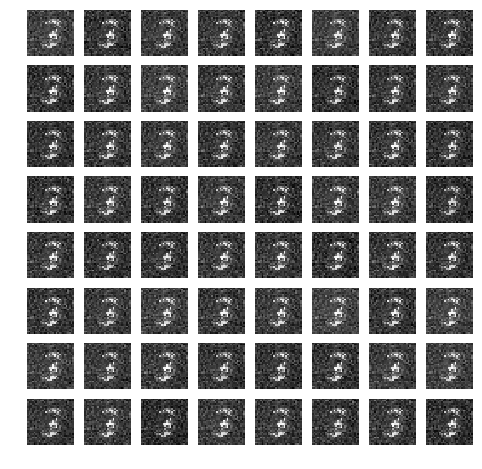

50::ELBO: 2.218e+02::Loss sampler: -1.274e+01:: Log prob: 1.464e+02:: Loss: 3.554e+02:: Time: 1.06e+02
100::ELBO: 1.715e+02::Loss sampler: -1.326e+01:: Log prob: 1.072e+02:: Loss: 2.655e+02:: Time: 1.01e+02
150::ELBO: 1.509e+02::Loss sampler: -1.451e+01:: Log prob: 8.909e+01:: Loss: 2.255e+02:: Time: 1.01e+02
200::ELBO: 1.482e+02::Loss sampler: -1.501e+01:: Log prob: 8.174e+01:: Loss: 2.150e+02:: Time: 1.01e+02
250::ELBO: 1.429e+02::Loss sampler: -6.174e+00:: Log prob: 7.794e+01:: Loss: 2.146e+02:: Time: 1.01e+02
300::ELBO: 1.389e+02::Loss sampler: -1.116e+01:: Log prob: 7.701e+01:: Loss: 2.047e+02:: Time: 1.01e+02
350::ELBO: 1.405e+02::Loss sampler: -1.340e+01:: Log prob: 7.704e+01:: Loss: 2.041e+02:: Time: 1.01e+02
400::ELBO: 1.368e+02::Loss sampler: -1.330e+01:: Log prob: 7.273e+01:: Loss: 1.962e+02:: Time: 1.01e+02
450::ELBO: 1.346e+02::Loss sampler: -1.343e+01:: Log prob: 7.143e+01:: Loss: 1.926e+02:: Time: 1.01e+02
500::ELBO: 1.287e+02::Loss sampler: -1.205e+01:: Log prob: 6.750e

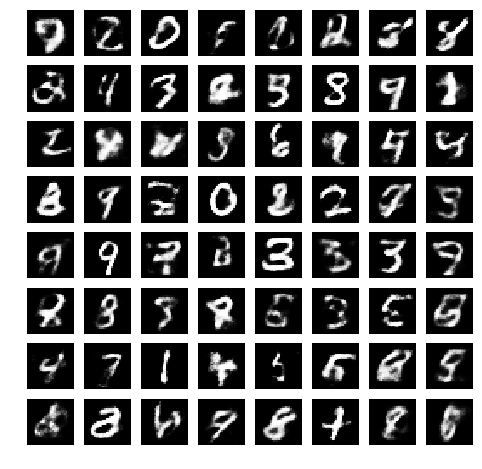

2050::ELBO: 1.251e+02::Loss sampler: -8.493e+00:: Log prob: 6.189e+01:: Loss: 1.785e+02:: Time: 1.05e+02
2100::ELBO: 1.246e+02::Loss sampler: -8.323e+00:: Log prob: 6.094e+01:: Loss: 1.772e+02:: Time: 1.01e+02
2150::ELBO: 1.266e+02::Loss sampler: -3.714e-01:: Log prob: 6.210e+01:: Loss: 1.883e+02:: Time: 1.01e+02
2200::ELBO: 1.259e+02::Loss sampler: -7.990e+00:: Log prob: 6.260e+01:: Loss: 1.805e+02:: Time: 1.01e+02
2250::ELBO: 1.266e+02::Loss sampler: -8.148e+00:: Log prob: 6.062e+01:: Loss: 1.790e+02:: Time: 1.01e+02
2300::ELBO: 1.220e+02::Loss sampler: -7.835e+00:: Log prob: 6.021e+01:: Loss: 1.744e+02:: Time: 1.01e+02
2350::ELBO: 1.247e+02::Loss sampler: -2.756e+00:: Log prob: 6.140e+01:: Loss: 1.834e+02:: Time: 1.01e+02
2400::ELBO: 1.253e+02::Loss sampler: -7.883e+00:: Log prob: 6.290e+01:: Loss: 1.803e+02:: Time: 1.01e+02
2450::ELBO: 1.257e+02::Loss sampler: -8.047e+00:: Log prob: 6.046e+01:: Loss: 1.781e+02:: Time: 1.01e+02
2500::ELBO: 1.224e+02::Loss sampler: -7.236e+00:: Log p

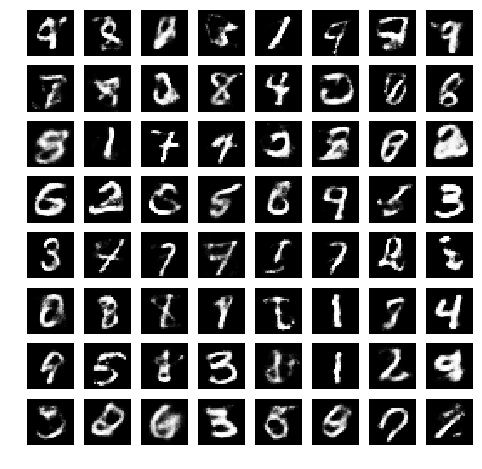

4050::ELBO: 1.245e+02::Loss sampler: -6.288e+00:: Log prob: 6.012e+01:: Loss: 1.784e+02:: Time: 1.07e+02
4100::ELBO: 1.200e+02::Loss sampler: -6.355e+00:: Log prob: 5.777e+01:: Loss: 1.714e+02:: Time: 1.01e+02
4150::ELBO: 1.246e+02::Loss sampler: -6.405e+00:: Log prob: 6.093e+01:: Loss: 1.791e+02:: Time: 1.01e+02
4200::ELBO: 1.237e+02::Loss sampler: 1.111e+00:: Log prob: 5.952e+01:: Loss: 1.843e+02:: Time: 1.01e+02
4250::ELBO: 1.191e+02::Loss sampler: -3.870e+00:: Log prob: 5.659e+01:: Loss: 1.718e+02:: Time: 1.01e+02
4300::ELBO: 1.210e+02::Loss sampler: -5.917e+00:: Log prob: 5.749e+01:: Loss: 1.725e+02:: Time: 1.01e+02
4350::ELBO: 1.253e+02::Loss sampler: -5.621e+00:: Log prob: 6.101e+01:: Loss: 1.807e+02:: Time: 1.01e+02
4400::ELBO: 1.209e+02::Loss sampler: -4.182e+00:: Log prob: 5.742e+01:: Loss: 1.742e+02:: Time: 1.01e+02
4450::ELBO: 1.255e+02::Loss sampler: -5.539e+00:: Log prob: 6.084e+01:: Loss: 1.808e+02:: Time: 1.01e+02
4500::ELBO: 1.251e+02::Loss sampler: -6.042e+00:: Log pr

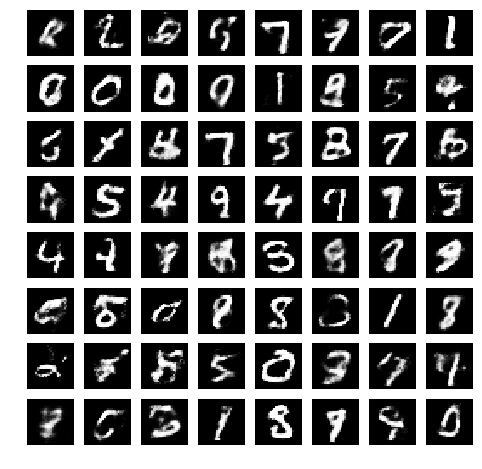

6050::ELBO: 1.196e+02::Loss sampler: -5.282e+00:: Log prob: 5.655e+01:: Loss: 1.709e+02:: Time: 1.05e+02
6100::ELBO: 1.199e+02::Loss sampler: -2.155e+00:: Log prob: 5.689e+01:: Loss: 1.746e+02:: Time: 1.01e+02
6150::ELBO: 1.202e+02::Loss sampler: -5.214e+00:: Log prob: 5.701e+01:: Loss: 1.720e+02:: Time: 1.01e+02
6200::ELBO: 1.217e+02::Loss sampler: -5.250e+00:: Log prob: 5.765e+01:: Loss: 1.741e+02:: Time: 1.01e+02
6250::ELBO: 1.203e+02::Loss sampler: -5.058e+00:: Log prob: 5.650e+01:: Loss: 1.718e+02:: Time: 1.01e+02
6300::ELBO: 1.217e+02::Loss sampler: 1.285e+00:: Log prob: 5.753e+01:: Loss: 1.805e+02:: Time: 1.01e+02
6350::ELBO: 1.215e+02::Loss sampler: -5.008e+00:: Log prob: 5.721e+01:: Loss: 1.737e+02:: Time: 1.01e+02
6400::ELBO: 1.181e+02::Loss sampler: -5.382e+00:: Log prob: 5.609e+01:: Loss: 1.688e+02:: Time: 1.01e+02
6450::ELBO: 1.199e+02::Loss sampler: -4.549e+00:: Log prob: 5.607e+01:: Loss: 1.714e+02:: Time: 1.01e+02
6500::ELBO: 1.205e+02::Loss sampler: 9.627e+00:: Log pro

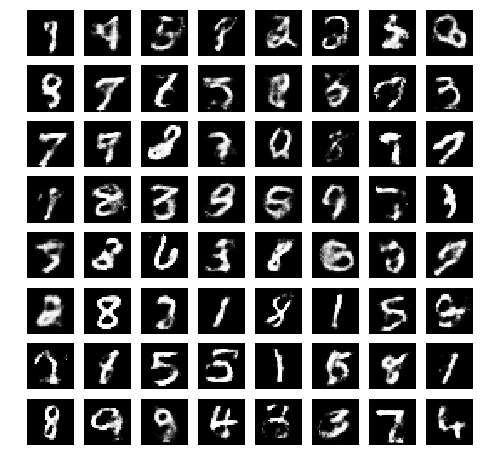

8050::ELBO: 1.184e+02::Loss sampler: 3.785e-01:: Log prob: 5.508e+01:: Loss: 1.738e+02:: Time: 1.05e+02
8100::ELBO: 1.177e+02::Loss sampler: -5.185e+00:: Log prob: 5.412e+01:: Loss: 1.666e+02:: Time: 1.01e+02
8150::ELBO: 1.199e+02::Loss sampler: -5.161e+00:: Log prob: 5.522e+01:: Loss: 1.699e+02:: Time: 1.01e+02
8200::ELBO: 1.242e+02::Loss sampler: -5.027e+00:: Log prob: 5.826e+01:: Loss: 1.774e+02:: Time: 1.01e+02
8250::ELBO: 1.209e+02::Loss sampler: -5.056e+00:: Log prob: 5.728e+01:: Loss: 1.732e+02:: Time: 1.01e+02
8300::ELBO: 1.215e+02::Loss sampler: 1.080e+01:: Log prob: 5.702e+01:: Loss: 1.893e+02:: Time: 1.01e+02
8350::ELBO: 1.220e+02::Loss sampler: -4.867e+00:: Log prob: 5.740e+01:: Loss: 1.745e+02:: Time: 1.01e+02
8400::ELBO: 1.210e+02::Loss sampler: 2.286e+00:: Log prob: 5.715e+01:: Loss: 1.805e+02:: Time: 1.01e+02
8450::ELBO: 1.235e+02::Loss sampler: -4.209e+00:: Log prob: 5.724e+01:: Loss: 1.765e+02:: Time: 1.01e+02
8500::ELBO: 1.191e+02::Loss sampler: -5.137e+00:: Log prob

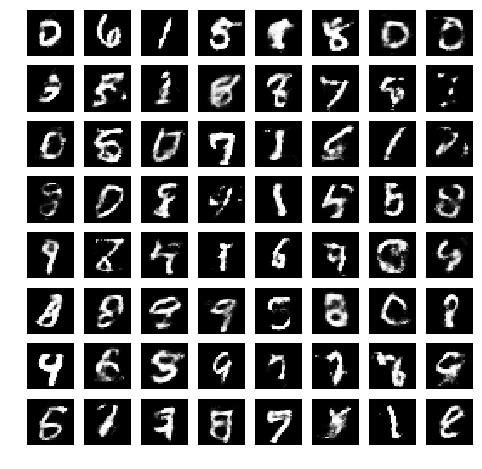

10050::ELBO: 1.188e+02::Loss sampler: -4.647e+00:: Log prob: 5.436e+01:: Loss: 1.685e+02:: Time: 1.05e+02
10100::ELBO: 1.191e+02::Loss sampler: -4.299e+00:: Log prob: 5.448e+01:: Loss: 1.693e+02:: Time: 1.01e+02
10150::ELBO: 1.219e+02::Loss sampler: -4.565e+00:: Log prob: 5.720e+01:: Loss: 1.746e+02:: Time: 1.01e+02
10200::ELBO: 1.180e+02::Loss sampler: -4.429e+00:: Log prob: 5.481e+01:: Loss: 1.684e+02:: Time: 1.01e+02
10250::ELBO: 1.179e+02::Loss sampler: -4.631e+00:: Log prob: 5.407e+01:: Loss: 1.674e+02:: Time: 1.01e+02
10300::ELBO: 1.208e+02::Loss sampler: -4.265e+00:: Log prob: 5.597e+01:: Loss: 1.725e+02:: Time: 1.01e+02
10350::ELBO: 1.163e+02::Loss sampler: -4.598e+00:: Log prob: 5.407e+01:: Loss: 1.658e+02:: Time: 1.01e+02
10400::ELBO: 1.187e+02::Loss sampler: -3.079e+00:: Log prob: 5.519e+01:: Loss: 1.708e+02:: Time: 1.01e+02
10450::ELBO: 1.196e+02::Loss sampler: -4.352e+00:: Log prob: 5.494e+01:: Loss: 1.702e+02:: Time: 1.01e+02
10500::ELBO: 1.204e+02::Loss sampler: -4.453e+

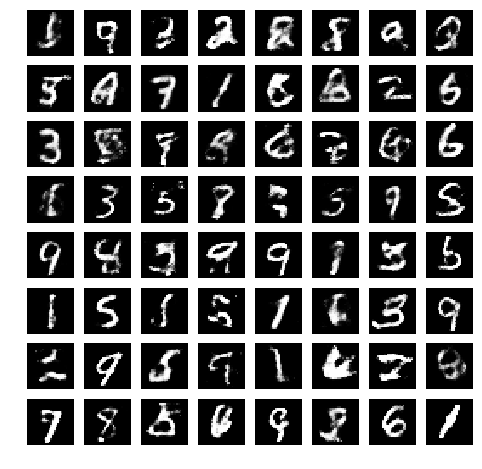

12050::ELBO: 1.181e+02::Loss sampler: -3.282e+00:: Log prob: 5.415e+01:: Loss: 1.690e+02:: Time: 1.06e+02
12100::ELBO: 1.173e+02::Loss sampler: 1.299e+01:: Log prob: 5.296e+01:: Loss: 1.832e+02:: Time: 1.01e+02
12150::ELBO: 1.157e+02::Loss sampler: -3.954e+00:: Log prob: 5.302e+01:: Loss: 1.648e+02:: Time: 1.01e+02
12200::ELBO: 1.175e+02::Loss sampler: -3.987e+00:: Log prob: 5.273e+01:: Loss: 1.663e+02:: Time: 1.01e+02
12250::ELBO: 1.173e+02::Loss sampler: -3.504e+00:: Log prob: 5.378e+01:: Loss: 1.676e+02:: Time: 1.01e+02
12300::ELBO: 1.179e+02::Loss sampler: -3.945e+00:: Log prob: 5.496e+01:: Loss: 1.689e+02:: Time: 1.01e+02
12350::ELBO: 1.173e+02::Loss sampler: -3.679e+00:: Log prob: 5.466e+01:: Loss: 1.683e+02:: Time: 1.01e+02
12400::ELBO: 1.194e+02::Loss sampler: -3.998e+00:: Log prob: 5.373e+01:: Loss: 1.691e+02:: Time: 1.01e+02
12450::ELBO: 1.178e+02::Loss sampler: -3.867e+00:: Log prob: 5.416e+01:: Loss: 1.681e+02:: Time: 1.01e+02
12500::ELBO: 1.190e+02::Loss sampler: -3.988e+0

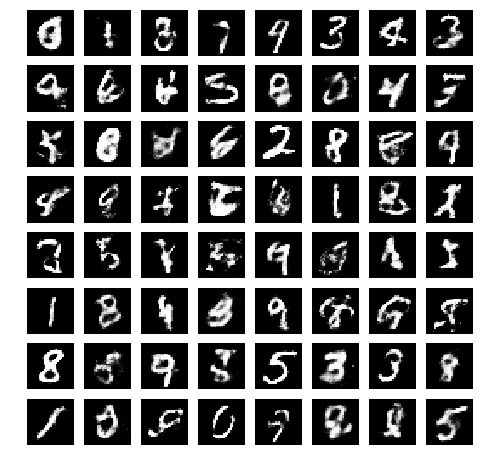

14050::ELBO: 1.138e+02::Loss sampler: -3.924e+00:: Log prob: 5.082e+01:: Loss: 1.607e+02:: Time: 1.08e+02
14100::ELBO: 1.169e+02::Loss sampler: -3.867e+00:: Log prob: 5.287e+01:: Loss: 1.659e+02:: Time: 1.01e+02
14150::ELBO: 1.175e+02::Loss sampler: -3.861e+00:: Log prob: 5.199e+01:: Loss: 1.656e+02:: Time: 1.01e+02
14200::ELBO: 1.160e+02::Loss sampler: -3.786e+00:: Log prob: 5.182e+01:: Loss: 1.640e+02:: Time: 1.01e+02
14250::ELBO: 1.150e+02::Loss sampler: -3.833e+00:: Log prob: 5.128e+01:: Loss: 1.625e+02:: Time: 1.01e+02
14300::ELBO: 1.143e+02::Loss sampler: -3.769e+00:: Log prob: 5.180e+01:: Loss: 1.623e+02:: Time: 1.01e+02
14350::ELBO: 1.172e+02::Loss sampler: -3.810e+00:: Log prob: 5.144e+01:: Loss: 1.648e+02:: Time: 1.01e+02
14400::ELBO: 1.160e+02::Loss sampler: -3.646e+00:: Log prob: 5.138e+01:: Loss: 1.637e+02:: Time: 1.01e+02
14450::ELBO: 1.206e+02::Loss sampler: -3.695e+00:: Log prob: 5.447e+01:: Loss: 1.714e+02:: Time: 1.01e+02
14500::ELBO: 1.167e+02::Loss sampler: 9.317e-0

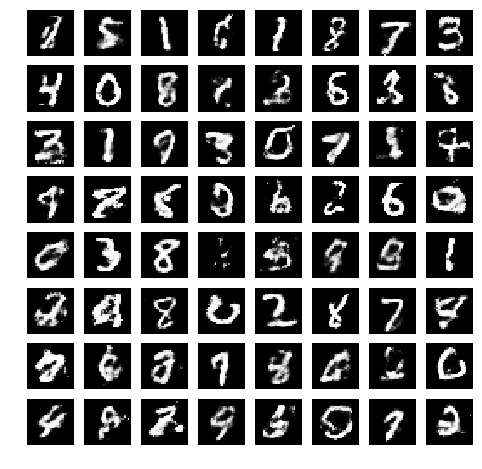

16050::ELBO: 1.155e+02::Loss sampler: -3.452e+00:: Log prob: 5.118e+01:: Loss: 1.633e+02:: Time: 1.05e+02
16100::ELBO: 1.171e+02::Loss sampler: 1.980e+00:: Log prob: 5.168e+01:: Loss: 1.708e+02:: Time: 1.01e+02
16150::ELBO: 1.179e+02::Loss sampler: -3.324e+00:: Log prob: 5.285e+01:: Loss: 1.674e+02:: Time: 1.01e+02
16200::ELBO: 1.200e+02::Loss sampler: -3.356e+00:: Log prob: 5.281e+01:: Loss: 1.695e+02:: Time: 1.01e+02
16250::ELBO: 1.196e+02::Loss sampler: -3.141e+00:: Log prob: 5.258e+01:: Loss: 1.690e+02:: Time: 1.01e+02
16300::ELBO: 1.148e+02::Loss sampler: -3.248e+00:: Log prob: 5.033e+01:: Loss: 1.619e+02:: Time: 1.01e+02
16350::ELBO: 1.168e+02::Loss sampler: -2.665e+00:: Log prob: 5.223e+01:: Loss: 1.663e+02:: Time: 1.01e+02
16400::ELBO: 1.164e+02::Loss sampler: -3.102e+00:: Log prob: 5.171e+01:: Loss: 1.650e+02:: Time: 1.01e+02
16450::ELBO: 1.170e+02::Loss sampler: -3.063e+00:: Log prob: 5.172e+01:: Loss: 1.657e+02:: Time: 1.01e+02
16500::ELBO: 1.183e+02::Loss sampler: -3.101e+0

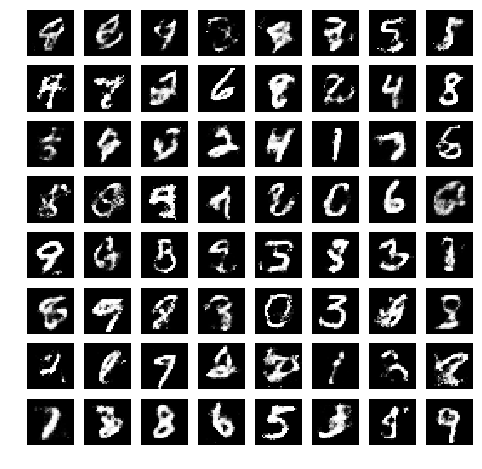

18050::ELBO: 1.172e+02::Loss sampler: -3.238e+00:: Log prob: 5.197e+01:: Loss: 1.660e+02:: Time: 1.05e+02
18100::ELBO: 1.159e+02::Loss sampler: -5.941e-01:: Log prob: 5.096e+01:: Loss: 1.663e+02:: Time: 1.01e+02
18150::ELBO: 1.152e+02::Loss sampler: -3.200e+00:: Log prob: 4.999e+01:: Loss: 1.620e+02:: Time: 1.01e+02
18200::ELBO: 1.184e+02::Loss sampler: -3.190e+00:: Log prob: 5.294e+01:: Loss: 1.682e+02:: Time: 1.01e+02
18250::ELBO: 1.128e+02::Loss sampler: -2.906e+00:: Log prob: 4.933e+01:: Loss: 1.592e+02:: Time: 1.01e+02
18300::ELBO: 1.168e+02::Loss sampler: -2.991e+00:: Log prob: 4.987e+01:: Loss: 1.637e+02:: Time: 1.01e+02
18350::ELBO: 1.173e+02::Loss sampler: -2.969e+00:: Log prob: 5.134e+01:: Loss: 1.656e+02:: Time: 1.01e+02
18400::ELBO: 1.146e+02::Loss sampler: -3.043e+00:: Log prob: 4.979e+01:: Loss: 1.614e+02:: Time: 1.01e+02
18450::ELBO: 1.178e+02::Loss sampler: 3.552e+00:: Log prob: 5.239e+01:: Loss: 1.737e+02:: Time: 1.01e+02
18500::ELBO: 1.137e+02::Loss sampler: -2.922e+0

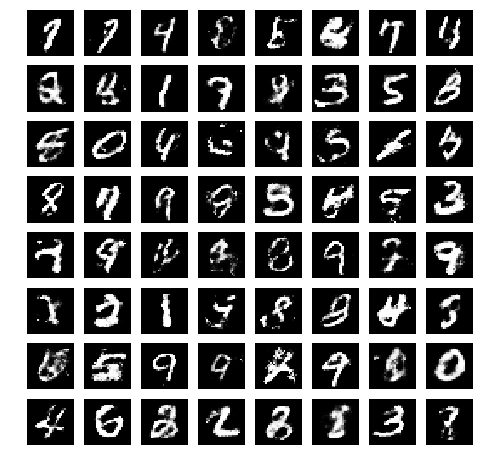

20050::ELBO: 1.154e+02::Loss sampler: -2.679e+00:: Log prob: 4.996e+01:: Loss: 1.627e+02:: Time: 1.06e+02
20100::ELBO: 1.133e+02::Loss sampler: 4.966e+00:: Log prob: 4.853e+01:: Loss: 1.668e+02:: Time: 1.01e+02
20150::ELBO: 1.159e+02::Loss sampler: -2.846e+00:: Log prob: 4.834e+01:: Loss: 1.614e+02:: Time: 1.01e+02
20200::ELBO: 1.151e+02::Loss sampler: -2.660e+00:: Log prob: 4.847e+01:: Loss: 1.609e+02:: Time: 1.01e+02
20250::ELBO: 1.144e+02::Loss sampler: 5.079e+00:: Log prob: 4.949e+01:: Loss: 1.690e+02:: Time: 1.01e+02
20300::ELBO: 1.195e+02::Loss sampler: -2.756e+00:: Log prob: 5.131e+01:: Loss: 1.681e+02:: Time: 1.01e+02
20350::ELBO: 1.159e+02::Loss sampler: -2.737e+00:: Log prob: 5.013e+01:: Loss: 1.633e+02:: Time: 1.01e+02
20400::ELBO: 1.162e+02::Loss sampler: -2.721e+00:: Log prob: 4.999e+01:: Loss: 1.634e+02:: Time: 1.01e+02
20450::ELBO: 1.178e+02::Loss sampler: -2.719e+00:: Log prob: 5.065e+01:: Loss: 1.657e+02:: Time: 1.01e+02
20500::ELBO: 1.179e+02::Loss sampler: 5.144e+00:

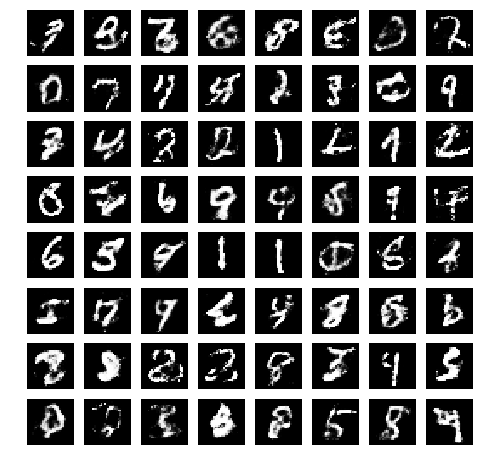

22050::ELBO: 1.166e+02::Loss sampler: -2.517e+00:: Log prob: 4.909e+01:: Loss: 1.632e+02:: Time: 1.06e+02
22100::ELBO: 1.186e+02::Loss sampler: -2.576e+00:: Log prob: 5.060e+01:: Loss: 1.667e+02:: Time: 1.01e+02
22150::ELBO: 1.171e+02::Loss sampler: -2.498e+00:: Log prob: 4.995e+01:: Loss: 1.646e+02:: Time: 1.01e+02
22200::ELBO: 1.158e+02::Loss sampler: -2.584e+00:: Log prob: 4.926e+01:: Loss: 1.625e+02:: Time: 1.01e+02
22250::ELBO: 1.162e+02::Loss sampler: -2.525e+00:: Log prob: 4.925e+01:: Loss: 1.629e+02:: Time: 1.01e+02
22300::ELBO: 1.172e+02::Loss sampler: -2.656e+00:: Log prob: 5.018e+01:: Loss: 1.648e+02:: Time: 1.01e+02
22350::ELBO: 1.181e+02::Loss sampler: -2.689e+00:: Log prob: 4.942e+01:: Loss: 1.649e+02:: Time: 1.01e+02
22400::ELBO: 1.166e+02::Loss sampler: -2.610e+00:: Log prob: 5.011e+01:: Loss: 1.642e+02:: Time: 1.01e+02
22450::ELBO: 1.186e+02::Loss sampler: -2.700e+00:: Log prob: 5.031e+01:: Loss: 1.662e+02:: Time: 1.01e+02
22500::ELBO: 1.189e+02::Loss sampler: -2.465e+

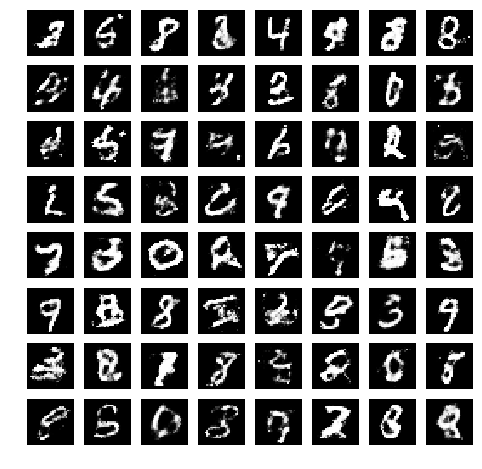

24050::ELBO: 1.153e+02::Loss sampler: -2.420e+00:: Log prob: 4.772e+01:: Loss: 1.606e+02:: Time: 1.08e+02
24100::ELBO: 1.134e+02::Loss sampler: -2.500e+00:: Log prob: 4.799e+01:: Loss: 1.589e+02:: Time: 1.01e+02
24150::ELBO: 1.178e+02::Loss sampler: -2.522e+00:: Log prob: 4.844e+01:: Loss: 1.637e+02:: Time: 1.01e+02
24200::ELBO: 1.127e+02::Loss sampler: 1.303e+01:: Log prob: 4.686e+01:: Loss: 1.726e+02:: Time: 1.01e+02
24250::ELBO: 1.173e+02::Loss sampler: -2.528e+00:: Log prob: 4.842e+01:: Loss: 1.632e+02:: Time: 1.01e+02
24300::ELBO: 1.184e+02::Loss sampler: -2.492e+00:: Log prob: 5.004e+01:: Loss: 1.660e+02:: Time: 1.01e+02
24350::ELBO: 1.183e+02::Loss sampler: -2.544e+00:: Log prob: 5.024e+01:: Loss: 1.660e+02:: Time: 1.01e+02
24400::ELBO: 1.183e+02::Loss sampler: -2.429e+00:: Log prob: 4.921e+01:: Loss: 1.651e+02:: Time: 1.01e+02
24450::ELBO: 1.171e+02::Loss sampler: -2.444e+00:: Log prob: 5.072e+01:: Loss: 1.653e+02:: Time: 1.01e+02
24500::ELBO: 1.177e+02::Loss sampler: -2.447e+0

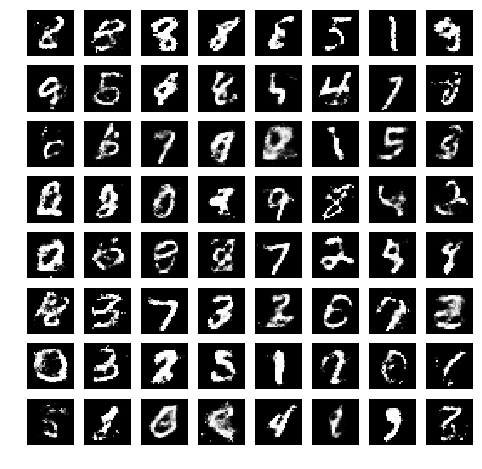

26050::ELBO: 1.157e+02::Loss sampler: -2.091e+00:: Log prob: 4.902e+01:: Loss: 1.626e+02:: Time: 1.06e+02
26100::ELBO: 1.155e+02::Loss sampler: -2.083e+00:: Log prob: 4.805e+01:: Loss: 1.614e+02:: Time: 1.01e+02
26150::ELBO: 1.193e+02::Loss sampler: -2.066e+00:: Log prob: 4.833e+01:: Loss: 1.656e+02:: Time: 1.01e+02
26200::ELBO: 1.194e+02::Loss sampler: -2.132e+00:: Log prob: 4.938e+01:: Loss: 1.666e+02:: Time: 1.01e+02
26250::ELBO: 1.139e+02::Loss sampler: -2.130e+00:: Log prob: 4.722e+01:: Loss: 1.590e+02:: Time: 1.01e+02
26300::ELBO: 1.188e+02::Loss sampler: -2.149e+00:: Log prob: 4.863e+01:: Loss: 1.653e+02:: Time: 1.01e+02
26350::ELBO: 1.164e+02::Loss sampler: -2.198e+00:: Log prob: 4.672e+01:: Loss: 1.609e+02:: Time: 1.01e+02
26400::ELBO: 1.196e+02::Loss sampler: -2.071e+00:: Log prob: 4.999e+01:: Loss: 1.675e+02:: Time: 1.01e+02
26450::ELBO: 1.166e+02::Loss sampler: -2.114e+00:: Log prob: 4.930e+01:: Loss: 1.638e+02:: Time: 1.01e+02
26500::ELBO: 1.178e+02::Loss sampler: -2.135e+

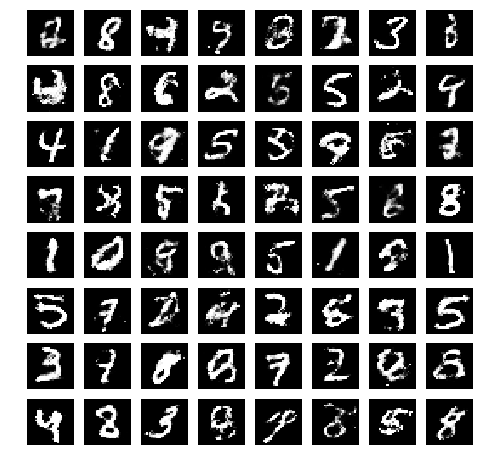

28050::ELBO: 1.173e+02::Loss sampler: -2.225e+00:: Log prob: 4.835e+01:: Loss: 1.635e+02:: Time: 1.06e+02
28100::ELBO: 1.167e+02::Loss sampler: -2.082e+00:: Log prob: 4.786e+01:: Loss: 1.624e+02:: Time: 1.01e+02
28150::ELBO: 1.133e+02::Loss sampler: -2.132e+00:: Log prob: 4.655e+01:: Loss: 1.577e+02:: Time: 1.01e+02
28200::ELBO: 1.169e+02::Loss sampler: -1.869e+00:: Log prob: 4.727e+01:: Loss: 1.623e+02:: Time: 1.01e+02
28250::ELBO: 1.151e+02::Loss sampler: 1.512e-01:: Log prob: 4.723e+01:: Loss: 1.625e+02:: Time: 1.01e+02
28300::ELBO: 1.124e+02::Loss sampler: -2.160e+00:: Log prob: 4.595e+01:: Loss: 1.562e+02:: Time: 1.01e+02
28350::ELBO: 1.163e+02::Loss sampler: -2.107e+00:: Log prob: 4.750e+01:: Loss: 1.617e+02:: Time: 1.01e+02
28400::ELBO: 1.179e+02::Loss sampler: -2.233e+00:: Log prob: 4.796e+01:: Loss: 1.637e+02:: Time: 1.01e+02
28450::ELBO: 1.163e+02::Loss sampler: -1.986e+00:: Log prob: 4.827e+01:: Loss: 1.626e+02:: Time: 1.01e+02
28500::ELBO: 1.138e+02::Loss sampler: -2.156e+0

KeyboardInterrupt: 

In [18]:
# from tensorflow.python.client import timeline
# builder = tf.profiler.ProfileOptionBuilder

# tf.profiler.profile(
#     tf.get_default_graph(),
#     options=builder.trainable_variables_parameter())
    
sess = tf.Session()

sess.run(tf.global_variables_initializer())

L = []

time0 = time.time()

for t in range(int(5e4)):
#     run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
#     run_metadata = tf.RunMetadata()
    
    ind = np.random.randint(low=0, high=60000, size=(256,))
    batch = x_train[ind, :]
#     run_metadata = tf.RunMetadata()
    elbo_, sampler_loss_, log_prob_, _, _, _ = sess.run([
        elbo,
        sampler_loss,
        log_prob,
        elbo_train_op,
        sampler_train_op,
        decoder_train_op,
    ], {inp: batch, dynamics.temperature: 1.0, lr: 1e-3},
#         options=tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE),
#         run_metadata=run_metadata,
    )
    
#     tf.profiler.profile(
#         tf.get_default_graph(),
#         run_meta=run_metadata,
#         cmd='op',
#         options=builder(builder.time_and_memory()).order_by('micros').build())
    
    L.append(elbo_+sampler_loss_+log_prob_)

    if t % 50 == 0:
        print '%d::ELBO: %.3e::Loss sampler: %.3e:: Log prob: %.3e:: Loss: %.3e:: Time: %.2e' \
            % (t, elbo_, sampler_loss_, log_prob_, (elbo_+sampler_loss_+log_prob_), time.time()-time0)
        time0 = time.time()
        
    if t % 2000 == 0:
        S = sess.run(x_eval)
        S = np.reshape(S, (-1, 28, 28))
        plot_grid(S)
        plt.show()
#     fetched_timeline = timeline.Timeline(run_metadata.step_stats)
#     chrome_trace = fetched_timeline.generate_chrome_trace_format()
#     with open('timeline_01.json', 'w') as f:
#         f.write(chrome_trace)
#     tf.profiler.advise(tf.get_default_graph, run_meta=run_metadata)

In [51]:
z1 = np.random.randn(1, 50)
z1 = np.tile(z1, (100, 1))
z1[:, 1] = np.arange(-1., 1., 0.02)

In [43]:
for l in a:
    Z.append(z1 * l + z2 * (1-l))

In [44]:
ZZ = np.stack(Z)[0].T
ZZ.shape

(100, 50)

In [45]:
z_eval = tf.placeholder(tf.float32, shape=(None, 50))
x_eval = tf.nn.sigmoid(decoder(z_eval))

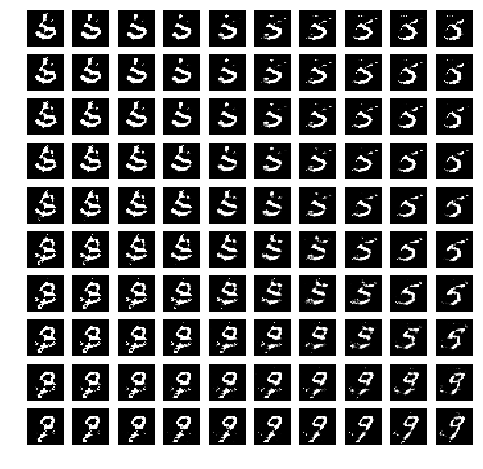

In [55]:
z1 = np.random.randn(50)
z2 = np.random.randn(50)
z3 = np.random.randn(50)
z4 = np.random.randn(50)

Z = []
for a in np.arange(-1, 1, 0.2):
    for b in np.arange(-1, 1, 0.2):
        z = z1 * a + z2 * (1-a) + z3 * b + z4 * (1-b)
        Z += [z]
        
S = sess.run(x_eval, {z_eval: np.stack(Z)})
S = np.reshape(S, (-1, 28, 28))
plot_grid(S, width=10)
plt.show()

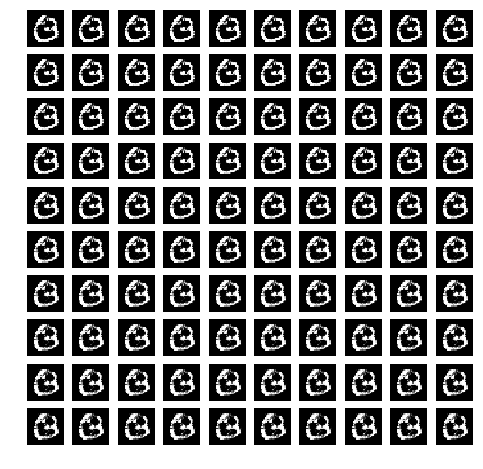

In [ ]:
def loss_func(x, Lx, px):
    v1 = tf.reduce_sum(tf.square(x - Lx), axis=1) * px + 1e-4
    scale = 1.0

    sampler_loss = 0.
    sampler_loss += scale * (tf.reduce_mean(1.0 / v1))
    sampler_loss += (- tf.reduce_mean(v1)) / scale
    return sampler_loss

def tf_accept(x, Lx, px):
    mask = (px - tf.random_uniform(tf.shape(px)) >= 0.)
    return tf.where(mask, Lx, x)

sampler_loss = 0.

latent = latent_q
for t in range(4):
    mask = tf.random_uniform((tf.shape(x)[0],), maxval=2, dtype=tf.int32)
    x1, x2 = tf.dynamic_partition(x, mask, 2)
    aux1, aux2 = tf.dynamic_partition(inp, mask, 2)
    
    Lx1, _, px1 = dynamics.forward(x1, aux=aux1)
    Lx2, _, px2 = dynamics.backward(x2, aux=aux2)
    
    Lx = inverse_boolean_mask(Lx1, Lx2, mask)
    px = inverse_boolean_mask(px1, px2, mask)
    
    sampler_loss += loss_func(x, Lx, px)
    
    latent = tf_accept(x, Lx, px)

latent_T = latent

In [ ]:
#sess.run(tf.variables_initializer(var_from_scope('sampler')))
#sess.run(tf.variables_initializer(var_from_scope('aux')))
sampler_train_op = optimizer.minimize(loss2, var_list=var_from_scope('sampler'))
nb_steps = 5000

dN = np.shape(x_train)[0]
posterior_samples = sess.run(mu + noise * tf.exp(log_sigma), {inp: x_train})

print 'Approximate posterior samples'

sample_acc_prob = []
noise_acc_prob = []

loss_values = []

temp = 1.0

for t in range(nb_steps):
    ind = np.random.randint(low=0, high=60000, size=(128,))
    for tt in range(5):
        feed_dict={
            x: posterior_samples[ind, :],
            aux: x_train[ind, :],
            dynamics.temperature: temp,
            lr: 1e-3,
        }

        _, loss_sampler, Lx_, px_ = sess.run([
            sampler_train_op,
            loss2,
            Lx,
            px,
        ], feed_dict)

        sample_acc_prob.append(np.mean(px_))

        new_posterior_samples = accept(posterior_samples[ind, :], Lx_, px_)
        posterior_samples[ind, :] = new_posterior_samples
        loss_values.append(loss_sampler)
  
    if t % 50 == 0:
        print 'Step: %d / %d, Loss: %.2e, Acceptance sample: %.2f, Epsilon: %.3f, LR: %.5f' % (t, nb_steps, loss_sampler, np.mean(px_),sess.run(dynamics.eps), sess.run(learning_rate, {lr: 1e-3}))

In [ ]:
hack_vars += [x for x in var_from_scope('') if 'global_step_1' in x.name]

In [ ]:
hack_vars += [x for x in var_from_scope('') if 'power_2' in x.name]

In [ ]:
hack_vars

In [ ]:
plt.plot(smooth(loss_values, k=100))
plt.ylim(-5, 5)

In [ ]:
px_

In [22]:
def smooth(l, k=25):
    return [np.mean(l[t:t+k]) for t in range(len(l) - k)]

In [ ]:
start_particles = sess.run(mu + noise * tf.exp(log_sigma), {inp: x_train[ind, :]})

In [ ]:
samples_ = np.copy(start_particles)

final_samples_list = []
 
for t in range(2000):
    Lx_, px_ = sess.run([Lx, px], {x: samples_, aux: x_train[ind, :]})
    samples_ = accept(samples_, Lx_, px_)

    final_samples_list.append(np.copy(samples_))

In [ ]:
F = np.array(final_samples_list)

In [ ]:
F.shape

In [ ]:
def auto_correlation_time(x, s, mu, var):
    b, t, d = x.shape
    act_ = np.zeros([d])
    for i in range(0, b):
        y = x[i] - mu[i]
        p, n = y[:-s], y[s:]
        act_ += np.mean(p * n, axis=0) / var
    act_ = act_ / b
    return act_

In [ ]:
F_conv = F[1000:, :, :]

In [ ]:
print 'alive?'

In [ ]:
mu = F_conv.mean(axis=0)

In [ ]:
mu.shape

In [ ]:
FF = np.transpose(F_conv, (1, 0, 2))

In [ ]:
plt.plot([auto_correlation_time(FF, t, mu, 1.) for t in range(500)])

In [ ]:
signal = F_conv[:, 0, :]

centered_signal = signal - np.mean(signal, axis=0)

In [ ]:
centered_signal.shape

In [ ]:
ft_signal = np.fft.fftn(centered_signal)

In [ ]:
powerSpectralDensity = np.abs(ft_signal)**2
autocovariance = np.fft.ifftn(powerSpectralDensity) / len(centered_signal)

In [ ]:
autocovariance = np.real(autocovariance)

In [ ]:
autocovariance.shape

In [ ]:
p = np.linalg.norm(autocovariance, axis=1)

In [ ]:
p.shape

In [ ]:
plt.plot(p)

In [ ]:
def autocovariance(X, tau=0):
    dT, dN, dX = np.shape(X)
    s = 0.
    for t in range(dT - tau):
        x1 = X[t, :, :]
        x2 = X[t+tau, :, :]

        s += np.sum(x1 * x2) / dN

    return s / (dT - tau)

In [ ]:
plt.plot(np.abs([autocovariance(F_conv - mu, tau=t) for t in range(999)]))

In [ ]:
with tf.variable_scope('hmc_sampler'):
    hmc_dynamics = Dynamics(x_dim, energy, T=3, eps=0.1, hmc=True, eps_trainable=False, use_temperature=False)

x_hmc = tf.placeholder(tf.float32, shape=(None, 50))
Lx_hmc, _, p_x_hmc = hmc_dynamics.forward(x_hmc, aux=aux)

In [ ]:
sess.run(tf.variables_initializer(var_from_scope('hmc_sampler')))

In [ ]:
samples_ = np.copy(start_particles)

hmc_samples_list = []
 
for t in range(2000):
    Lx_, px_ = sess.run([Lx_hmc, p_x_hmc], {x_hmc: samples_, aux: x_train[ind, :]})
    samples_ = accept(samples_, Lx_, px_)

    hmc_samples_list.append(np.copy(samples_))

In [ ]:
G = np.array(hmc_samples_list)[1000:, :, :]
plt.plot(np.abs([autocovariance(F_conv - mu, tau=t) for t in range(999)]), label='cosa nostra')
plt.plot(np.abs([autocovariance(G - mu, tau=t) for t in range(999)]), label='HMC')
plt.xlabel('MH steps')
plt.ylabel('Autocovariance')
plt.xlim(0, 200)
plt.legend()

In [15]:
def plot_grid(S, width=8):
    sheet_width = width
    plt.figure(figsize=(8, 8))
    for i in xrange(S.shape[0]):
        plt.subplot(sheet_width, sheet_width, i + 1)
        plt.imshow(S[i], cmap='gray')
        plt.grid('off')
        plt.axis('off')